### This is an automated workflow for nicely formatting output from ASU's `MERTools:MERspect` software.

Simply modify the variable values in the cell below and then "restart + rerun" the entire kernel. To avoid possible namespace collisions, you should _always_ "restart + rerun" after making a change. It's very fast.

#### Modify the following variable definitions in order to affect what is plotted and how.

The `spectra_fn` variable points to the CSV file containing the spectra.
The format of the spectra can be exactly how it was exported from MERspect, or it can be in the `marslab` format.

You can pass a list of spectra files to plot them all simultaneously, (like `[fn1.csv, fn2.csv]`) but be it might lead to confusing results if they use the same colors, and you will need to redefine `outfile`.

In [1]:
spectra_fn = "marslab/data/ZCAM_spectra/fakeIOFspectra.csv"

# If a MERspect formatted file is given, the default is to write a marslab-formatted file with the following tag.
tag = '-marslab'
# Define the output filename --- use `None` to deactivate this behavior.
outfile = spectra_fn.replace(f'{tag}.csv','.csv').replace('.csv',f'{tag}.csv')

The `annotation_string` prints in large characters in the lower left of the plot, rather than a title. You can put anything you want here, but we suggest identifying the sol, camera sequence ID, and target as in the example.

In [2]:
sol = 16
seq_id = 'zcamNNNN'
target_name = 'TargetName'
annotation_string = f'Sol016 : zcamNNNN : TargetName'

If the `solar_elevation` variable is set to a number other than `None`, it will perform the IOF->R* conversion. Only use this if you are sure that the spectra in `spectra_fn` are in units of IOF. (This is the `MERspect` default.) The value to use here can be found as `SOLAR_ELEVATION` in the image headers.

In [3]:
solar_elevation = None#78.3

The `scale_method` variable defines options for scaling the data at the overlapping (800nm) filter. This does not scale errors.
* `"scale_to_left"` - Scale the right eye filters to the left eye filter at 800nm (L1). Merspect default.
* `"scale_to_avg"` - Scale all filters to the average of L1/R1. Marslab default.
* `None` - no scaling

In [4]:
scale_method = "scale_to_avg"
assert(scale_method in ['scale_to_left', 'scale_to_avg', None]) # Tests that the variable has a valid value

The `color_to_feature` dictionary maps `MERspect` colors to a feature name string to be used in the label plot. The syntax should match that of the commented example below. Any colors that don't have a feature defined will be labeled by their color. If defined, the feature will also be written to the `FEATURE` column of the spectra table _if_ you passed a MERspect formatted spectra file; it will not be propagated if you passed a Marslab format file.

In [5]:
                      # Examples---
color_to_feature = {  #'blue' : 'interesting rock',
                      #'green': 'not a creative color',
                      #'red' : 'danger',
                      #'cyan' : 'shadow',
                      #'orange' : 'probably not aliens'
                    }

If this variable is set to a file path, the plot will be saved to that location. The filepath should include a filename that ends with a standard type of image suffix (e.g. `.jpg`, `.png`, `.tiff`).

In [6]:
plot_fn = None#"marslab/data/ZCAM_spectra/fakeIOFspectra.jpg"

And some additional parameters for the plot...

In [7]:
# Set the title of the plot
plot_title = 'Fake Spectra'

# This string defines the attribution to be placed in the lower right of the plot
credit = 'Credit:NASA/JPL/ASU/MSSS/Cornell/WWU/MC'

# This parameter defines the background color for the plot.
# Suggested values include 'white', 'whitesmoke', 'lightgray'
bgcolor = 'white'

# Toggle the edges of the plot that are visible as a black line
# Options are 'left','bottom','top','right'
plot_edges = ['left','bottom']
assert(edge in ['left','right','top','bottom'] for edge in plot_edges) # Tests that the variable has a valid value

The `underplot` variable toggles what is underplotted. The options are:
* `None` - Nothing is plotted.
* `"filter"` - The filter transmission profiles are plotted.
* `"grid"` - Gridlines are underplotted.

In [8]:
underplot = "filter"
assert(underplot in [None,'filter','grid']) # Tests that the variable has a valid value

### ----- DO NOT MODIFY ANYTHING BELOW THIS LINE UNLESS YOU ARE SURE -----

In [9]:
# These variables define the width and height of the output plot
# This could mess up the layout in annoying or ugly ways
plot_width = 15
plot_height = 12

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.font_manager as mplf

import numpy as np

import textwrap
from pathlib import Path

import pandas as pd
pd.options.display.max_columns = None

from marslab.compatibility import MERSPECT_COLOR_MAPPINGS, WAVELENGTH_TO_FILTER
from marslab.reference import lab_spectra
from marslab.convert import scale_eyes, merspect_to_marslab, convert_for_plot

import warnings
warnings.filterwarnings('ignore') # Comment this out for testing

##### Define translation between filter wavelengths + eyes to filter designations

In [11]:
# Import lookup table from filter center wavelength and eye to filter designation
wavelength_to_filter = WAVELENGTH_TO_FILTER

# Now define the inverse operation to map filter designation to center wavelength
f2w = dict((v, [k]) for k, v in wavelength_to_filter['ZCAM']['L'].items())
for k, v in wavelength_to_filter['ZCAM']['R'].items():
    f2w[v]=[k]
filter_to_wavelength=pd.DataFrame(f2w)

In [12]:
# Import the conversion between merspect color names and hex codes
color_mappings = MERSPECT_COLOR_MAPPINGS

# Define allowable symbols to use in plots, in increasing preference.
# TODO: The "right" way to loop these is probably to use iter.cycle()
sym = ['s','o','D','p','^','v','P','X','*','d','H','8','h']*100

##### Convert IOF->R* if `solar_elevation` is defined

In [13]:
# This is exactly how MERspect defines the IOF->R* conversion
theta_rad = (90 - solar_elevation) * 2 * np.pi / 360 if solar_elevation else 2*np.pi

##### Translate from `MERspect` to `marslab` format. Save the `marslab`-formatted spectra file.

In [14]:
data = convert_for_plot(spectra_fn,scale_method=scale_method,color_to_feature=color_to_feature)
print('WWU Marslab spectra format:')
display(data)
if outfile:
    print(f"Saving table to {outfile}")
    data.to_csv(outfile,index=None)
data.replace("-", np.nan, inplace=True) # to simplify calculations

WWU Marslab spectra format:


,SOL,SEQ_ID,INSTRUMENT,COLOR,FEATURE,FORMATION,MEMBER,FLOAT,L6,L6_ERR,L0B,L0B_ERR,R0B,R0B_ERR,L5,L5_ERR,L0G,L0G_ERR,R0G,R0G_ERR,L4,L4_ERR,L0R,L0R_ERR,R0R,R0R_ERR,L3,L3_ERR,L2,L2_ERR,L1,L1_ERR,R1,R1_ERR,R2,R2_ERR,R3,R3_ERR,R4,R4_ERR,R5,R5_ERR,R6,R6_ERR
0,-,-,-,green,-,-,-,-,0.210450,0.004197,0.241525,0.006612,0.254889,0.006424,0.315524,0.006623,0.259521,0.006574,0.275572,0.005244,0.217107,0.004768,0.229730,0.002691,0.193483,0.002559,0.217635,0.003753,0.249012,0.002603,0.219417,0.002962,0.219417,0.002212,0.288745,0.008226,0.380791,0.008530,0.460198,0.008344,0.475872,0.011458,0.493447,0.008954
1,-,-,-,blue,-,-,-,-,0.068841,0.031233,0.099862,0.037195,0.129625,0.043139,0.130523,0.075218,0.142162,0.086745,0.206898,0.068998,0.188383,0.083589,0.196986,0.089811,0.187630,0.083313,0.211238,0.091555,0.197929,0.105833,0.189889,0.095180,0.189889,0.094479,0.160098,0.092987,0.136374,0.091430,0.165718,0.085224,0.170030,0.085018,0.214306,0.076812
2,-,-,-,red,-,-,-,-,0.593161,0.017491,0.594134,0.022398,0.555710,0.014406,0.595088,0.018540,0.597166,0.018846,0.543675,0.014125,0.582696,0.013482,0.588514,0.012136,0.548309,0.012046,0.595819,0.016630,0.585025,0.014195,0.548206,0.014259,0.548206,0.015740,0.537048,0.021199,0.541906,0.021456,0.547418,0.017329,0.544638,0.015866,0.553821,0.015427


Saving table to marslab/data/ZCAM_spectra/fakeIOFspectra-marslab.csv


In [15]:
# Remap the colors to feature names
color_to_feature = dict(zip(data['COLOR'].values,data['FEATURE'].values))
for k in color_to_feature.keys():
    if pd.isnull(color_to_feature[k]):
        color_to_feature[k]=k

##### Initialize font properties

In [16]:
# path to file containing referenced font
titillium = 'static/fonts/TitilliumWeb-Light.ttf'

# can also include other face properties, different fonts, etc.
label_fp = mplf.FontProperties(fname=titillium, size=20)
title_fp = mplf.FontProperties(fname=titillium, size=18)
tick_fp = mplf.FontProperties(fname=titillium, size=15)
legend_fp = mplf.FontProperties(fname=titillium, size=14)
tick_minor_fp = mplf.FontProperties(fname=titillium, size=11)
citation_fp = mplf.FontProperties(fname=titillium, size=12)
metadata_fp = mplf.FontProperties(fname=titillium, size=22)

##### Create some helper functions for generating the plot

In [17]:
def despine(ax,edges=['top','bottom','left','right']):
    # Remove the bounding box for a given subplot object axes
    for p in edges:
        ax.spines[p].set_visible(False)

In [18]:
def plot_filter_profiles(ax,inst='ZCAM'):
    # Underplot the filter profiles
    assert(inst in ['ZCAM','MCAM','PCAM'])
    p = Path(f"marslab/data/{inst}_filter_profiles/")
    for fn in p.glob('*csv'):
        filter_profile = pd.read_csv(fn,header=None)
        if ('R0' in str(fn)) or ('R1' in str(fn)):
            continue
        # The filter responses are on the interval [0,1]. Scale this to the data range.
        scaled_response = filter_profile[1].values*datarange[1]/filter_profile[1].max()
        ix = np.where(scaled_response>0.002) # don't plot effectively zero response
        ax.plot(filter_profile[0].values[ix],
                 scaled_response[ix],
                 f'k{":" if ("L0" in str(fn)) else "--"}',
                 alpha=0.07 if ('L0' in str(fn)) else 0.08)

def plot_lab_spectra(ax,minerals=[]):
    # Define the right axis for the lab data labels
    pry = ax.twinx()
    despine(pry) # remove the bounding box
    pry.set_yticks([]) # wipe auto-ticks or they stick around
    pry.set_ylim(ax.get_ylim())
    
    # Plot the requested lab spectra
    s = {}
    _=[s.update(lab_spectra[k]) for k in lab_spectra.keys()]
    ticks,labels=[],[]
    for i,m in enumerate(minerals):
        data = pd.read_csv(s[m],skiprows=17)#pd.read_csv(s[m],names=['Wavelength','Response'])
        data_inplot = data.loc[data['Wavelength']>=pry.get_xlim()[0]].loc[data['Wavelength']<pry.get_xlim()[1]]
        ylim = (pry.get_ylim()[0]+.1,ax.get_ylim()[1]-.1)
        data_scaled = (data_inplot['Response']
                       -np.min(data_inplot['Response']))*np.diff(ylim)/(np.max(data_inplot['Response'])-np.min(data_inplot['Response']))+ylim[0]
        pry.plot(data_inplot['Wavelength'],
                #data_scaled,
                 data_inplot['Response'],
                 'k',alpha=0.7,linewidth=2,
                )
        ticks+=[data_inplot['Response'].values[-1]]
        labels+=[m.replace(' ','\n')]
    pry.set_yticks(ticks)
    pry.set_yticklabels(labels,fontproperties=legend_fp)


##### Get some summary information about the data to be plotted to help define the plot structure

In [19]:
# Pre-define the plot extents so that they are easy to reuse
lpad, rpad = 20,60 # Creates a x-axis buffer for graphical layout reasons.
datadomain = [400-lpad,1100+rpad]
# To define the y-axis extent, we add a little margin to the actual min/max data values
#  and then round to the nearest tenth. The ylims will always be even tenths.
datarange = [np.floor(0.25*np.nanmin(data[[k for k in data.keys() if len(k)<=3 and k!='SOL']].values)/np.cos(theta_rad)*10)/10,
             np.ceil(1.05*np.nanmax(data[[k for k in data.keys() if len(k)<=3 and k!='SOL']].values)/np.cos(theta_rad)*10)/10]
datamean = np.nanmean(data[[k for k in data.keys() if len(k)<=3 and k!='SOL']].values)/np.cos(theta_rad)

##### Generate the plot

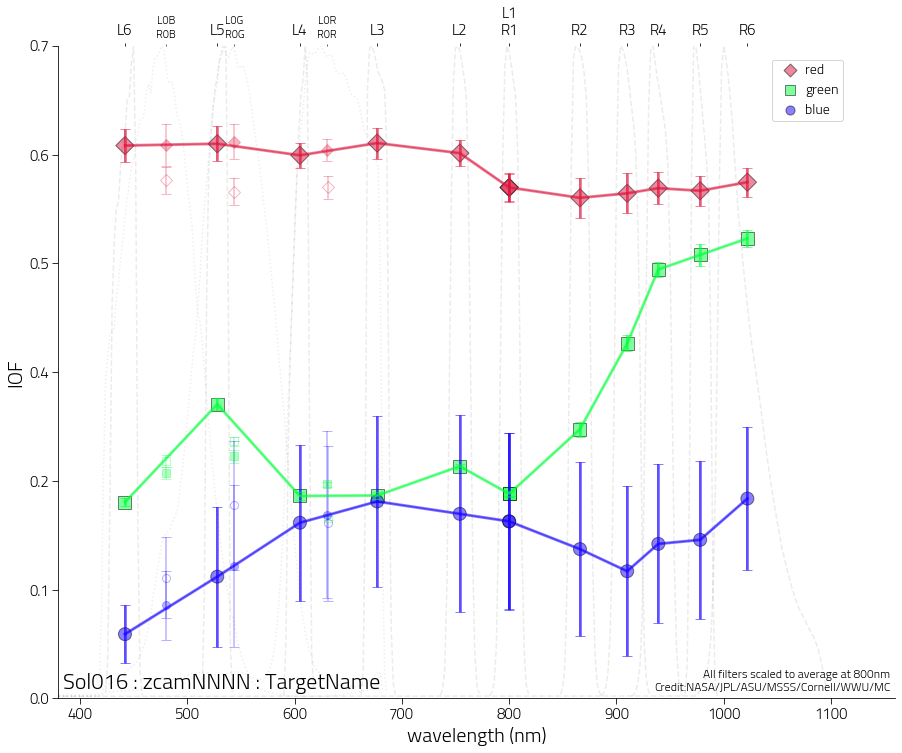

In [20]:
fig, ax = plt.subplots(figsize=(plot_width,plot_height),facecolor=bgcolor)

# Remove the bounding box
despine(ax)

ax.set_xlim(datadomain)

# Set the ticks for the bottom axis
ax.set_xticks(np.linspace(datadomain[0]+lpad,datadomain[1]-rpad,8));
ax.set_xticklabels(np.array(np.linspace(datadomain[0]+lpad,datadomain[1]-rpad,8),'int16').tolist(),
                   fontproperties=tick_fp);
ax.set_xlabel('wavelength (nm)', fontproperties=label_fp)

# Set the minor ticks of the top axis with the bayer filters
prx = ax.twiny()
#                  Remove spines _not_ listed in `plot_edges`
despine(prx,edges=[d for d in ['left','right','top','bottom'] if not d in plot_edges])
prx.set_xticks([]) # wipe auto-ticks or they stick around
prx.set_xticks((filter_to_wavelength[[k for k in data.keys() if (len(k)==3) and 'L0' in k]].values[0]-datadomain[0])/(datadomain[1]-datadomain[0]),
               minor=True);
prx.set_xticklabels([f"L0{k[-1]}\nR0{k[-1]}" for k in data.keys() if (len(k)==3) and 'L0' in k],
                    minor=True,fontproperties=tick_minor_fp);
# Set the major ticks of the top axis with the narrow band filters
prx.set_xticks((filter_to_wavelength[[k for k in data.keys() if (len(k)<=3
                 and not 'R0' in k and not 'L0' in k and not 'SOL' in k and not 'R1' in k)]].values[0]-datadomain[0])/(datadomain[1]-datadomain[0]));
prx.set_xticklabels([k.replace('L1','L1\nR1') for k in data.keys() if (len(k)<=3
                 and not 'R0' in k and not 'L0' in k and not 'SOL' in k and not 'R1' in k)],
                   fontproperties=tick_fp);

if underplot=='filter':
    plot_filter_profiles(ax)
elif underplot=='grid':
    ax.grid(axis='y',alpha=0.2)
    ax.grid(axis='x',alpha=0.2)

ax.set_ylim(datarange)
ax.set_ylabel('R* = IOF/cos('r'$\theta$)' if solar_elevation else 'IOF', fontproperties=label_fp)

# Set the ticks for the left yaxis
ax.set_yticks(np.linspace(datarange[0],datarange[1],int(1+(datarange[1]-datarange[0])/.1)));
ax.set_yticklabels(np.round(np.linspace(datarange[0],datarange[1],int(1+(datarange[1]-datarange[0])/.1)),1),                   
                  fontproperties=tick_fp);
ax.tick_params(length=6)

# Plot the requested lab spectra - dev functionality
#plot_lab_spectra(ax,minerals=["Pyrrhotite","Magnetite","Ferrosilite"])

# Plot the observational data
for i in range(len(data.index)):
    # Plot L bayer and other filters (no R bayer) as connected
    full_spectrum = [k for k in data.keys() if (len(k)<=3
                     and not 'R0' in k and not 'L0' in k and not 'SOL' in k and np.isfinite(data.iloc[i][k]))]
    markersizes = [8 if len(k)==3 else 13 for k in full_spectrum] # plot bayers w/ smaller symbols
    ix = np.argsort(filter_to_wavelength[full_spectrum].values[0])
    # plot the errorbars
    ax.errorbar(filter_to_wavelength[full_spectrum].values[0][ix],
                 data.iloc[i][full_spectrum][ix]/np.cos(theta_rad),
                 yerr=data.iloc[i][[f'{f}_ERR' for f in full_spectrum]][ix],
                 fmt=f'',color=color_mappings[data['COLOR'].values[i]],
                 alpha=0.5,capsize=5)

    # plot the line
    ax.errorbar(filter_to_wavelength[full_spectrum].values[0][ix],
                 data.iloc[i][full_spectrum][ix]/np.cos(theta_rad),
                 yerr=data.iloc[i][[f'{f}_ERR' for f in full_spectrum]][ix],
                 fmt=f'-',color=color_mappings[data['COLOR'].values[i]],
                 markersize=10,alpha=0.5,linewidth=3)
    
    #plot the symbols
    ax.scatter(filter_to_wavelength[full_spectrum].values[0][ix],
                 data.iloc[i][full_spectrum][ix]/np.cos(theta_rad),
                 marker=f'{sym[i]}',color=color_mappings[data['COLOR'].values[i]],
                 edgecolors='k',
                 s=np.array(markersizes)[ix]**2, # scatter takes units of pixel**2
                 alpha=0.5,
                 label=('\n'.join(textwrap.wrap(color_to_feature[data['COLOR'].values[i]],
                                                width=10,break_long_words=False))
                        if data['COLOR'].values[i] in color_to_feature.keys() else data['COLOR'].values[i]))

    
    # Plot bayer separately as smaller markers, w/ left eye filled and right as outlines
    # TODO: add black outlines to the bayer filters
    for bayer in ['L0R','L0G','L0B','R0R','R0G','R0B']:
        ax.errorbar(filter_to_wavelength[bayer].values[0],data.iloc[i][bayer]/np.cos(theta_rad),
                     yerr=data.iloc[i][[f'{bayer}_ERR']],
                     fmt=f'{sym[i]}', color = color_mappings[data['COLOR'].values[i]],capsize=5,
                 fillstyle = 'none' if bayer.startswith('R') else 'full',markersize=8,alpha=0.3)
ax.set_zorder(1) # adjust the rendering order of twin axes
ax.set_frame_on(False) # make it transparent

# Reorder the legend to match the R6 filter.
# TODO: Reorder according to the longest wavelength filter with data.
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.array(handles)[np.argsort(data['R6'].values)].tolist()[::-1],
          np.array(labels)[np.argsort(data['R6'].values)].tolist()[::-1],
          loc=2,bbox_to_anchor=[
              (1038-datadomain[0])/(datadomain[1]-datadomain[0]), # left edge goes at 1038nm
              0.99],
          labelspacing=.5,borderpad=.3,prop=legend_fp,facecolor='white',markerscale=0.7,handletextpad=.1)

# Add an annotation to define the observation
ax.annotate(
    annotation_string,
    xy=(0,0), xycoords='axes fraction',
    xytext=(5, 5),
    textcoords='offset pixels',
    horizontalalignment='left',
    verticalalignment='bottom',
    fontproperties=metadata_fp
)

# Add the citation string w/ information about scaling
ax.annotate(
    {'scale_to_avg':f'All filters scaled to average at 800nm',
     'scale_to_left':f'Right filter scaled to left at 800nm',
     None:''}[scale_method]+'\n'+credit,
    xy=(1, 0), 
    xycoords='axes fraction',
    xytext=(-5, 5), 
    textcoords='offset pixels',
    horizontalalignment='right',
    verticalalignment='bottom',
    fontproperties=citation_fp
)

if plot_fn:
    fig.savefig(plot_fn)

The contents of this notebook are provided by the Western Washington University Reflectance Lab (PI: M. Rice) and Million Concepts (C. Million, M. St. Clair) under a BSD 3-Clause License. You may do nearly anything that you want with this code. Questions can be sent to chase@millionconcepts.com

`MERTools`/`MERspect` is proprietary software (Arizona State University) for rover tactical operations made available on an as-needed basis.